In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import constants as cnst, u_darrays as uda
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import salem
import cartopy
import xarray as xr
import glob
import ipdb
# Some defaults
cmap = plt.get_cmap('RdBu_r')
sns.set_context('talk')
sns.set_style('ticks')

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
#mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_-40_allClouds_monthly.nc'
mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_count_-50_allClouds_monthly.nc'
chirps = '/media/ck/Elements/global/CHIRPS/chirps-v2.0.monthly.nc'
ndvi = '/media/ck/Elements/global/NDVI_monthly/*.nc'
fpath = cnst.network_data + 'figs/HUARAZ/'


In [4]:
altiplano = [-74.5, -65, -18, -15] # altiplano [-74, -61, -18, -15]#
peru = [-79, -74, -12, -7] #tropics
tbox = [-60,-50,-12,-5]

In [5]:
def load(isbuffer, mcs,chirps):
    fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
    topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
    da3 = xr.open_dataarray(mcs).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
    ca = xr.open_dataarray(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
#     ndvi = xr.open_mfdataset(ndvi_f)
#     ndvi = uda.flip_lat(ndvi)
#     ndvi = ndvi['CMG 0.05 Deg Monthly NDVI'].sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
    
    topo_on_da3 = da3.salem.lookup_transform(topo)
    da3 = da3.where(topo_on_da3>2000)

    topo_on_ca = ca.salem.lookup_transform(topo)
    ca = ca.where(topo_on_ca>2000)
    
    return da3, ca

In [6]:
alti_cloud, alti_rain = load(altiplano, mcs, chirps)

In [11]:
#peru_cloud, peru_rain , peru_ndvi= load(peru, mcs, chirps,ndvi)

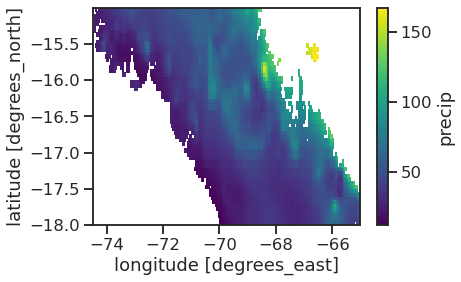

In [12]:
alti_rain.mean('time').plot()

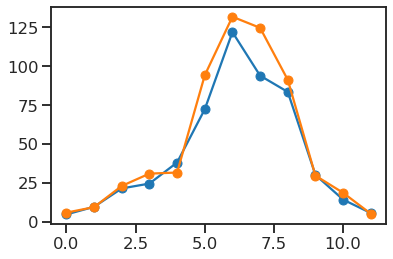

In [13]:
c_early = alti_rain.sel(time=((alti_rain['time.year']>=1985) & (alti_rain['time.year']<=1999))).groupby('time.month').mean(['time', 'latitude', 'longitude']).roll(month=6, roll_coords=True)
c_late = alti_rain.sel(time=((alti_rain['time.year']>=2000) & (alti_rain['time.year']<=2018))).groupby('time.month').mean(['time', 'latitude', 'longitude']).roll(month=6, roll_coords=True)
plt.plot( c_early, marker='o')
plt.plot(c_late, marker='o')

In [14]:
g_early = alti_cloud.sel(time=((alti_cloud['time.year']>=1985) & (alti_cloud['time.year']<=1999))).groupby('time.month').mean(['time', 'lat', 'lon']).roll(month=6, roll_coords=True)
g_late = alti_cloud.sel(time=((alti_cloud['time.year']>=2000) & (alti_cloud['time.year']<=2018))).groupby('time.month').mean(['time', 'lat', 'lon']).roll(month=6, roll_coords=True)
f = plt.figure()
plt.plot( g_early, marker='o')
plt.plot(g_late, marker='o')

In [15]:
da3 = alti_cloud.mean(['lat', 'lon'])*100
ca = alti_rain.mean(['latitude', 'longitude'])
#ndvi = alti_ndvi.where(alti_ndvi>=0).mean(['lat', 'lon'])

In [16]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

In [17]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}
def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [18]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
#     year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
#                                coords=[ds.time], name='year_season')

    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),coords=[ds.time],name='month_length')
    result = ((ds * month_length).resample(time='QS-JAN').sum() /  month_length.where(ds.notnull()).resample(time='QS-JAN').sum())  #QS-DEC

    # Calculate the weighted average
    #ipdb.set_trace()
    return result[result['time.month']==1]


In [19]:
# Wrap it into a simple function
def season_mean_ndvi(ds, calendar='standard'):
    # Make a DataArray of season/year groups
#     year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
#                                coords=[ds.time], name='year_season')

    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),coords=[ds.time],name='month_length')
    result = ((ds * month_length).resample(time='QS-JAN').sum() /  month_length.where(ds.notnull()).resample(time='QS-JAN').sum())  #QS-DEC

    # Calculate the weighted average
    #ipdb.set_trace()
    return result[result['time.month']==1]

In [20]:
gts = season_mean(da3)

In [21]:
cts = season_mean(ca)

In [22]:
nts = season_mean_ndvi(ndvi)

AttributeError: 'str' object has no attribute 'time'

In [220]:
ca

<xarray.DataArray 'precip' (time: 460)>
array([145.52838  , 156.26663  ,  89.90428  ,  43.055107 ,  11.101739 ,
         4.501384 ,   5.8312817,  14.765062 ,  31.13014  ,  38.55862  ,
        45.307617 ,  98.9131   , 132.20732  ,  79.889824 ,  98.229744 ,
        35.09609  ,   9.704727 ,   5.1785393,   5.5587363,  10.011733 ,
        30.159197 ,  41.063644 ,  68.853424 ,  39.79471  ,  62.521404 ,
        58.50604  ,  47.290764 ,  29.103886 ,  12.878991 ,   4.74949  ,
         5.979567 ,   9.445868 ,  26.124092 ,  16.36547  ,  22.635122 ,
        70.04028  , 195.66893  , 186.7635   , 143.68454  ,  31.15261  ,
        17.416    ,   8.011798 ,   6.6382685,  10.621087 ,  14.984978 ,
        49.056202 ,  85.65954  ,  91.26523  , 102.79935  , 150.54356  ,
       102.05665  ,  69.05958  ,  18.033445 ,   9.089299 ,   5.5759687,
         9.5526285,  34.98216  ,  23.357456 ,  67.30623  , 109.74805  ,
       141.02184  , 144.92903  , 141.08325  ,  49.481766 ,  14.168031 ,
         4.477742 ,   6.6791983,  12.312335 ,  33.297417 ,  14.8853855,
        34.77225  , 121.49277  , 176.81247  ,  57.72132  ,  50.175293 ,
        19.213203 ,  13.487011 ,   5.364881 ,   9.638684 ,   7.915004 ,
        16.349216 ,  27.07955  ,  57.338127 ,  50.37805  , 142.32445  ,
        73.42961  , 106.465805 ,  36.328697 ,  21.255672 ,   4.43387  ,
         5.864044 ,   6.630675 ,  21.124306 ,  20.018389 ,  19.210213 ,
        88.16985  , 130.56816  , 117.38691  , 105.9568   ,  37.09751  ,
...
         4.303371 ,   6.953834 ,   9.085377 ,  28.355959 ,  23.779379 ,
        36.50568  , 167.25006  , 130.50752  , 174.40869  , 138.54811  ,
        56.773586 ,  13.773543 ,   5.1421456,   6.131085 ,   7.2528715,
        27.105633 ,  21.284195 ,  44.278767 , 141.38855  , 124.02416  ,
       141.80684  , 106.92914  ,  15.802686 ,  26.43247  ,   6.9764524,
         6.808517 ,  15.1940775,  23.131966 ,  51.58481  ,  36.783417 ,
       146.01398  , 158.0446   , 108.05804  ,  96.09602  ,  34.98596  ,
        20.576729 ,   5.0601826,   7.031974 ,  11.465656 ,  57.35587  ,
        43.134243 ,  23.61952  , 110.30537  , 141.04486  , 119.78345  ,
       118.28903  ,  57.215473 ,  29.171846 ,   5.7892504,   9.413114 ,
        10.764869 ,  27.614594 ,  28.252647 ,  31.529839 ,  78.38072  ,
        78.46662  , 152.91933  ,  67.84244  ,  45.80915  ,  17.133232 ,
         5.393368 ,  11.562691 ,  13.469266 ,  28.10872  ,  38.700027 ,
        20.859873 ,  97.02248  , 158.0609   , 123.48047  , 126.53112  ,
        40.81255  ,  42.419903 ,   5.0338936,   7.014428 ,   7.869744 ,
        35.99547  ,  41.074936 ,  36.206154 , 100.70631  , 145.79654  ,
       137.19136  , 137.55856  ,  34.73617  ,  42.346966 ,  13.941317 ,
        13.210105 ,  11.532527 ,  21.266386 ,  57.73797  ,  44.288273 ,
       137.29366  , 126.66047  , 160.8827   ,  91.94126  ,  46.529507 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2019-04-01

In [23]:
def readERA(var):

    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_big.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [24]:
def readERA_coarse(var):

    u200orig = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/monthly/pressure_levels/synop/ERA5_monthly_pl_*_synop.nc')
   # ipdb.set_trace()
    u200orig = u200orig[var[0]].sel(level=int(var[1::]))
    try:
        u200orig = u200orig.isel(expver=0)
    except:
        pass
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
  #  ipdb.set_trace()
    return u200orig.load()

In [26]:
era = readERA('v850')
isjet = [-67,-61,-18,-14] #[-67,-62,-18,-15]#
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(isjet[0], isjet[1]), lat=slice(isjet[2], isjet[3]))
topo_on_era = era.salem.lookup_transform(topo)
era = era.where(topo_on_era < 1000)

era = era.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3]))    #vwind in western amazon

In [27]:
era['v'][0,:,:].plot()

In [28]:
era.time

<xarray.DataArray 'time' (time: 14610)>
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31

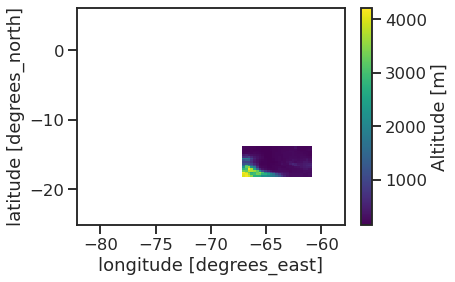

In [29]:
topo_on_era.plot()

In [30]:
isbuffer = altiplano
era_valley = era['v'].mean(['latitude', 'longitude']) #salem.roi(shape=sdf)  #'v'
ets = season_mean(era_valley)

In [31]:
era2 = readERA('u200')
era2 = era2.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
era2_valley = era2['u'].where(topo_on_era >2000).mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
ets200 = season_mean(era2_valley)

In [32]:
era2 = readERA_coarse('u200')
isatlantic= [-50,-25,0,10]
era2 = era2.sel(longitude=slice(isatlantic[0], isatlantic[1]), latitude=slice(isatlantic[2], isatlantic[3]))
era2_valley = era2.mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
ets200_atlantic = season_mean(era2_valley)

In [33]:
era2 = readERA_coarse('u850')
isatlantic= [-50,-25,0,10]
era2 = era2.sel(longitude=slice(isatlantic[0], isatlantic[1]), latitude=slice(isatlantic[2], isatlantic[3]))
era2_valley = era2.mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
ets850_atlantic = season_mean(era2_valley)

In [34]:
ets200_atlantic

<xarray.DataArray (time: 43)>
array([ 8.9362289 ,  8.22525725, 11.22356436,  6.9529354 , 18.42593463,
        7.43358314,  7.78330778,  9.37059255, 16.44679633, 10.05854518,
        7.73848012, 13.62676627, 10.72022744, 14.80587096, 13.42993623,
        8.33982185, 10.34544849,  5.89604602,  9.6517748 , 17.37084759,
        5.22272414,  1.98914053, 11.21036306, 11.60158591, 12.00001614,
        4.95769704,  7.41168873,  7.89131062,  8.80123111,  6.84223729,
        5.9758012 , 14.16675067,  3.10624359,  9.18805887, 10.69498336,
       13.32803128, 14.88955529, 16.47167765,  6.37122416,  9.49473047,
       14.5948437 , 11.25077711, 11.54668522])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2021-01-01
    expver   int32 1
    level    int32 200

In [35]:
isbuffer = tbox
era2 = readERA_coarse('t600')
era2 = era2.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
era2_valley = era2.where(topo_on_era >3000).mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
ett850 = season_mean(era2_valley)

In [36]:
isbuffer = isjet
era2 = readERA_coarse('q600')
era2 = era2.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
era2_valley = era2.where(topo_on_era >3000).mean(['latitude', 'longitude']) #salem.roi(shape=sdf) ['u']
etq850 = season_mean(era2_valley)

In [37]:
posgrid = np.intersect1d(ets.time, gts.time)

gsat = gts.sel(time=posgrid)
ets = ets.sel(time=posgrid)


posgrid = np.intersect1d(ets.time, cts.time)
cts = cts.sel(time=posgrid)
ets200 = ets200.sel(time=posgrid)

In [38]:
ett850 = ett850.sel(time=posgrid)
etq850 = etq850.sel(time=posgrid)

In [39]:
ets200_atlantic =  ets200_atlantic.sel(time=posgrid)
ets850_atlantic =  ets850_atlantic.sel(time=posgrid)

In [40]:
etq850 = etq850.to_pandas()
ett850 = ett850.to_pandas()
ets200 = ets200.to_pandas()
ets = ets.to_pandas()
gts = gts.to_pandas()
cts = cts.to_pandas()
#nts = nts.to_pandas()

In [41]:
ets200_atlantic = ets200_atlantic.to_pandas()
ets850_atlantic = ets850_atlantic.to_pandas()

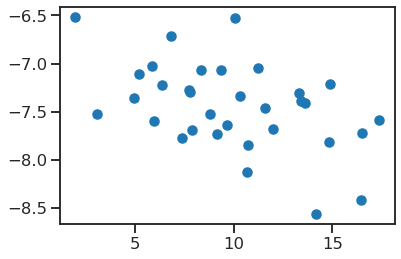

In [42]:
plt.scatter(ets200_atlantic,ets850_atlantic)

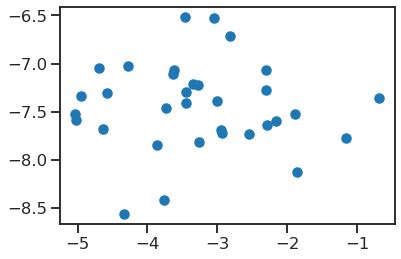

In [43]:
plt.scatter(ets,ets850_atlantic)

In [44]:
nts = nts.to_pandas()

NameError: name 'nts' is not defined

In [ ]:
plt.scatter(ett850-273.15, etq850*1000)

In [ ]:
plt.scatter(ets200_atlantic, ets200)

In [ ]:
plt.scatter(nts.loc[nts.index.year<=2017], ets200.loc[(ets200.index.year>=2000)])

In [ ]:
nts.loc[nts.index.year<=2017]

In [ ]:
enso = '/home/ck/DIR/mymachine/ENSO/ONI.csv'#'/home/ck/DIR/mymachine/ENSO/meiv2.data'
nao =  '/home/ck/DIR/mymachine/ENSO/NAO.csv'

In [ ]:
ysst_start = 1980#ets.index[0].year
ysst_end = 2019 #ets.index[-1].year

In [ ]:
ens = pd.read_csv(enso, sep=',', engine='python', names=np.arange(0, 13),index_col=0)
naos = pd.read_csv(nao, sep='  ', engine='python', names=np.arange(0, 13),index_col=0)
ensmonth = ens[1:3]
naomonth = naos[1:3]
eens = ensmonth.loc[ysst_start:ysst_end]
nnao = naomonth.loc[ysst_start:ysst_end]

In [ ]:
plt.plot(eens)
plt.plot(nnao)

In [ ]:
yens = ens.mean(axis = 1, skipna = True)[0:-1]
ynao =  naos.mean(axis = 1, skipna = True)[0:-1]

In [ ]:
plt.plot(yens[0:-1])
plt.plot(ynao[0:-1])

In [ ]:
yy1 = 2000
yy2 = 2017

In [ ]:
stats.pearsonr(nts[(nts.index.year>=yy1)&(nts.index.year<=yy2)], gts[(gts.index.year>=yy1)&(gts.index.year<=yy2)])

In [ ]:
stats.pearsonr(nts[(nts.index.year>=yy1)&(nts.index.year<=yy2)], cts[(cts.index.year>=yy1)&(cts.index.year<=yy2)])

In [ ]:
stats.pearsonr(gts[(gts.index.year>=yy1)&(gts.index.year<=yy2)], ensmonth.loc[yy1:yy2])

In [ ]:
stats.pearsonr(ets200_atlantic[(ets200_atlantic.index.year>=yy1)&(ets200_atlantic.index.year<=yy2)], ensmonth.loc[yy1:yy2])

In [ ]:
stats.pearsonr(ets200[(ets200.index.year>=yy1)&(ets200.index.year<=yy2)],ets200_atlantic[(ets200_atlantic.index.year>=yy1)&(ets200_atlantic.index.year<=yy2)])

In [ ]:
ccbar = []
for enb in eens.values:
    if enb < -0.5:
        ccbar.append('lightblue')
    elif enb > 0.5:
        ccbar. append('red')
    else:
        ccbar.append('k')

In [ ]:
ets.index

In [ ]:
stats.linregress(np.arange(len(ets200_atlantic)), ets200_atlantic)

In [ ]:
plt.plot(eens.index, eens, color='blue')

In [ ]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
#ax.plot((ett850-np.mean(ett850))*3, marker='o', label='v850hPa')

ax.plot((ets200-np.mean(ets200))/2, label='u200hPa', color='grey')
#ax.plot(ets.index, eens, color='k')
#ax.scatter(ets.index, eens, marker='x', color=ccbar)
plt.legend()
ax1 = ax.twinx()
ax1.plot((gts-np.mean(gts)), color='r', marker='o', label='-50C cloud cover frequency')
#ax1.plot((nts-np.mean(nts))*500, marker='o', label='v850hPa', color='blue')
ax1.plot((cts-np.mean(cts))/5, marker='o', label='v850hPa', color='green')
#print(ets.index[10:-5],stats.linregress(ets.values[10:-5], gts.values[10:-5]))
plt.title('DJF | Blue: v850hPa | Red: -50C cloud cover frequency')
ax1.set_ylabel('%')
ax.set_ylabel('m s$^{-1}$')
ax1.set_ylabel('%')
ax.set_ylabel('m s$^{-1}$')
ax.set_ylim(-4,4)
ax.set_ylim(ax.get_ylim()[::-1])
ax1.set_ylim(-14,14)
plt.axhline(0, linestyle='dashed', color='grey')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/interannual_timeseries_corr_GRIDSATvsv850WAmazon_Altiplano.jpg')

In [ ]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
#ax.plot((ets-np.mean(ets)), marker='o', label='v850hPa')

ax.plot((ets200-np.mean(ets200))/2, label='u200hPa', color='grey')
plt.legend()
#ax.plot((ets-np.mean(ets)).rolling(center=True,window=10).mean()*-1, color='purple')
ax1 = ax.twinx()
ax1.plot((cts-np.mean(cts)), color='r', marker='o', label='CHIRPS average rainfall')
ax.plot((ets-np.mean(ets)), marker='o', label='v850hPa', color='green')
print(ets.index[10:-5],stats.linregress(ets.values[10:-5], gts.values[10:-5]))
plt.title('DJF | Blue: v850hPa | Red: CHIRPS average rainfall')

plt.axhline(0, linestyle='dashed', color='grey')
ax.set_ylim(-4,4)
ax.set_ylim(ax.get_ylim()[::-1])
ax1.set_ylim(-45,45)

ax1.set_ylabel('mm month$^{-1}$')
ax.set_ylabel('m s$^{-1}$')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/interannual_timeseries_corr_CHIRPSv850WAmazon_Altiplano.jpg')

In [ ]:
stats.pearsonr(nts[(nts.index.year>=yy1)&(nts.index.year<=yy2)], cts[(cts.index.year>=yy1)&(cts.index.year<=yy2)])

In [ ]:
stats.pearsonr(nts[(nts.index.year>=yy1)&(nts.index.year<=yy2)], gts[(gts.index.year>=yy1)&(gts.index.year<=yy2)])

In [ ]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
plt.scatter(ets,gts, c=ets.index, cmap='Reds')

### Trend analysis 

In [ ]:
# the trend are computed on time series at least 20yrs long
start_years = ets.index[:-5]
start_years_p = start_years.year
end_years = ets.index[5:]
end_years_p = end_years.year
ny = len(start_years)
extent = (start_years_p[0], start_years_p[-1], end_years_p[0], end_years_p[-1])  # needed for the plot later

In [ ]:
extent

In [ ]:
# fill the triangle
trend = np.zeros((ny, ny)) *np.nan
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = ets200.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

In [ ]:
trend = np.array(trend)
sig = np.array(sig)

In [ ]:
plt.imshow(trend)
plt.colorbar()

In [ ]:
# plot
f= plt.figure(figsize=(9, 7),dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
# ax.set_xtick_labels(start_years_p)
# ax.set_ytick_labels(end_years_p)
plt.title('u200 vs WesternAmazon v850 p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_u200vsv850WesternAmazon_Altiplano.jpg')

In [ ]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = gts.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

In [ ]:
f= plt.figure(figsize=(9, 7), dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
plt.title('GRIDSAT correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
#plt.savefig('triangle_giss.png', dpi=150)
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_GRIDSATvsv850WesternAmazon_Altiplano.jpg')

In [ ]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        #ipdb.set_trace()
        data1 = yens.loc[start_year.year:end_year.year]
        data2 = ynao.loc[start_year.year:end_year.year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

In [ ]:
f= plt.figure(figsize=(9, 7), dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
plt.title('GRIDSAT correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
#plt.savefig('triangle_giss.png', dpi=150)
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_GRIDSATvsv850WesternAmazon_Altiplano.jpg')

In [ ]:
def monthly(m, d1,d2):

    dg = d1.sel(time=(d1['time.month']==m)).groupby('time.year').mean('time')
    de = d2.sel(time=(d2['time.month']==m)).groupby('time.year').mean('time')
                 
    posgrid = np.intersect1d(dg.year.values, de.year.values)

    de = de.sel(year=posgrid)
    dg = dg.sel(year=posgrid)
                 
    dg = dg.to_pandas()
    de = de.to_pandas()
                 
    # fill the triangle
    trend = np.zeros((ny, ny)) * np.NaN
    sig = np.ones((ny, ny)) 
    for i, start_year in enumerate(start_years_p):
        for j, end_year in enumerate(end_years_p):
            data1 = dg.loc[start_year:end_year]
            data2 = de.loc[start_year:end_year]
            if len(data1) < 5:
                continue
            slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
            trend[j, i] = r   # for decadal trends
            sig[j, i] = p_val
    
    return trend, sig

In [ ]:
f = plt.figure(figsize=(18,7), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,da3)
    

    ax = f.add_subplot(2,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(GRIDSAT) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);

plt.tight_layout() 
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_monthly_GRIDSATvsU200_Altiplano.jpg')

In [ ]:
f = plt.figure(figsize=(18,7), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,ca)
    

    ax = f.add_subplot(2,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(CHIRPS) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);
plt.tight_layout() 
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_monthly_CHIRPSvsU200_Altiplano.jpg')

In [ ]:
sst = xr.open_mfdataset('/media/ck/Elements/global/ERA5/monthly/uv/ERA5_monthly_0.7deg_*.nc')

In [ ]:
sst_full = uda.flip_lat(sst)

In [ ]:
ysst_start = ets.index[0].year
ysst_end = ets.index[-1].year

In [ ]:
sst = sst_full['u'].isel(time=(sst_full['time.year']>=ysst_start)&(sst_full['time.year']<=ysst_end)).sel(latitude=slice(-50,50))

In [ ]:
sst_full

In [ ]:
# Wrap it into a simple function
def season_mean_sst(ds, calendar='standard'):
    # Make a DataArray of season/year groups
#     year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
#                                coords=[ds.time], name='year_season')

    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),coords=[ds.time],name='month_length')
    result = ((ds * month_length).resample(time='QS-JAN').sum('time') /  month_length.where(ds.notnull()).resample(time='QS-JAN').sum('time'))  #QS-DEC

    # Calculate the weighted average
    #ipdb.set_trace()
    return result[result['time.month']==1]

In [ ]:
sst_season = season_mean_sst(sst)

In [ ]:
sst_season = sst_season.sel(level=850).load()

In [ ]:
mask = np.isnan(sst_season.sum('time'))

In [ ]:
sst_season.values[np.isnan(sst_season)]=0

In [ ]:
sst_season

In [ ]:
(ets200-ets).plot()

In [ ]:
def corr(a, b, bsingle=None, c_box=None):
    ds = xr.Dataset()
    ds['pval'] = a.copy(deep=True).sum('time') * np.nan
    ds['r'] = a.copy(deep=True).sum('time') * np.nan
    ds['slope'] = a.copy(deep=True).sum('time') * np.nan

    corr_box = c_box

    if bsingle:
        bb = b
    else:
        bb = b.sel(latitude=slice(corr_box[2], corr_box[3]), longitude=slice(corr_box[0], corr_box[1])).mean(dim=['latitude', 'longitude'])

    for lat in a.latitude.values:
        for lon in a.longitude.values:
            aa = a.sel(latitude=lat, longitude=lon)
            if bsingle:
                #r, p = stats.pearsonr(aa.values, bb)

                #pf = np.polyfit(aa.values, bb, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb)
            else:
                # r, p = stats.pearsonr(aa.values, bb.values)
                # pf = np.polyfit(aa.values, bb.values, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)


            slope = pf#[0]

            if (np.nansum(aa.values == 0) >= 10):
                p = np.nan
                r = np.nan

            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            #ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds

In [ ]:
ploops = [(gts,1984, 2000), (gts,2001,2018), (ets,1984,2000), (ets,2001,2019)]
outloops = []

In [ ]:
for pl in ploops:
    test = corr(sst_season.isel(time=(sst_season['time.year']>=pl[1]) & (sst_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    outloops.append(test)

In [ ]:
f = plt.figure(figsize=(15,5), dpi=300)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(outloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
    isy = ploops[ind]
        # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    tbox = [-50,-25,0,10]
    ax.add_patch(mpatches.Rectangle(xy=[tbox[0], tbox[2]], width=tbox[1]-tbox[0], height=tbox[3]-tbox[2], facecolor='blue', alpha=0.2, transform=ccrs.PlateCarree()))
    plt.contourf(sst_season.longitude, sst_season.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.contour(sst_season.longitude, sst_season.latitude, sst_season.isel(time=((sst_season['time.year']>=isy[1]) & (sst_season['time.year']<=isy[2]))).mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=[-10,-5,0,5,10])
    plt.colorbar()
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/large_scale/corr_u850_convectionTop_u200Bottom')

In [ ]:
f = plt.figure(figsize=(15,5), dpi=300)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(outloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
    isy = ploops[ind]
        # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst_season.longitude, sst_season.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.contour(sst_season.longitude, sst_season.latitude, sst_season.isel(time=((sst_season['time.year']>=isy[1]) & (sst_season['time.year']<=isy[2]))).mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=[-20,-10,-5,-2,0,2,5,10,20])
    plt.colorbar()
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

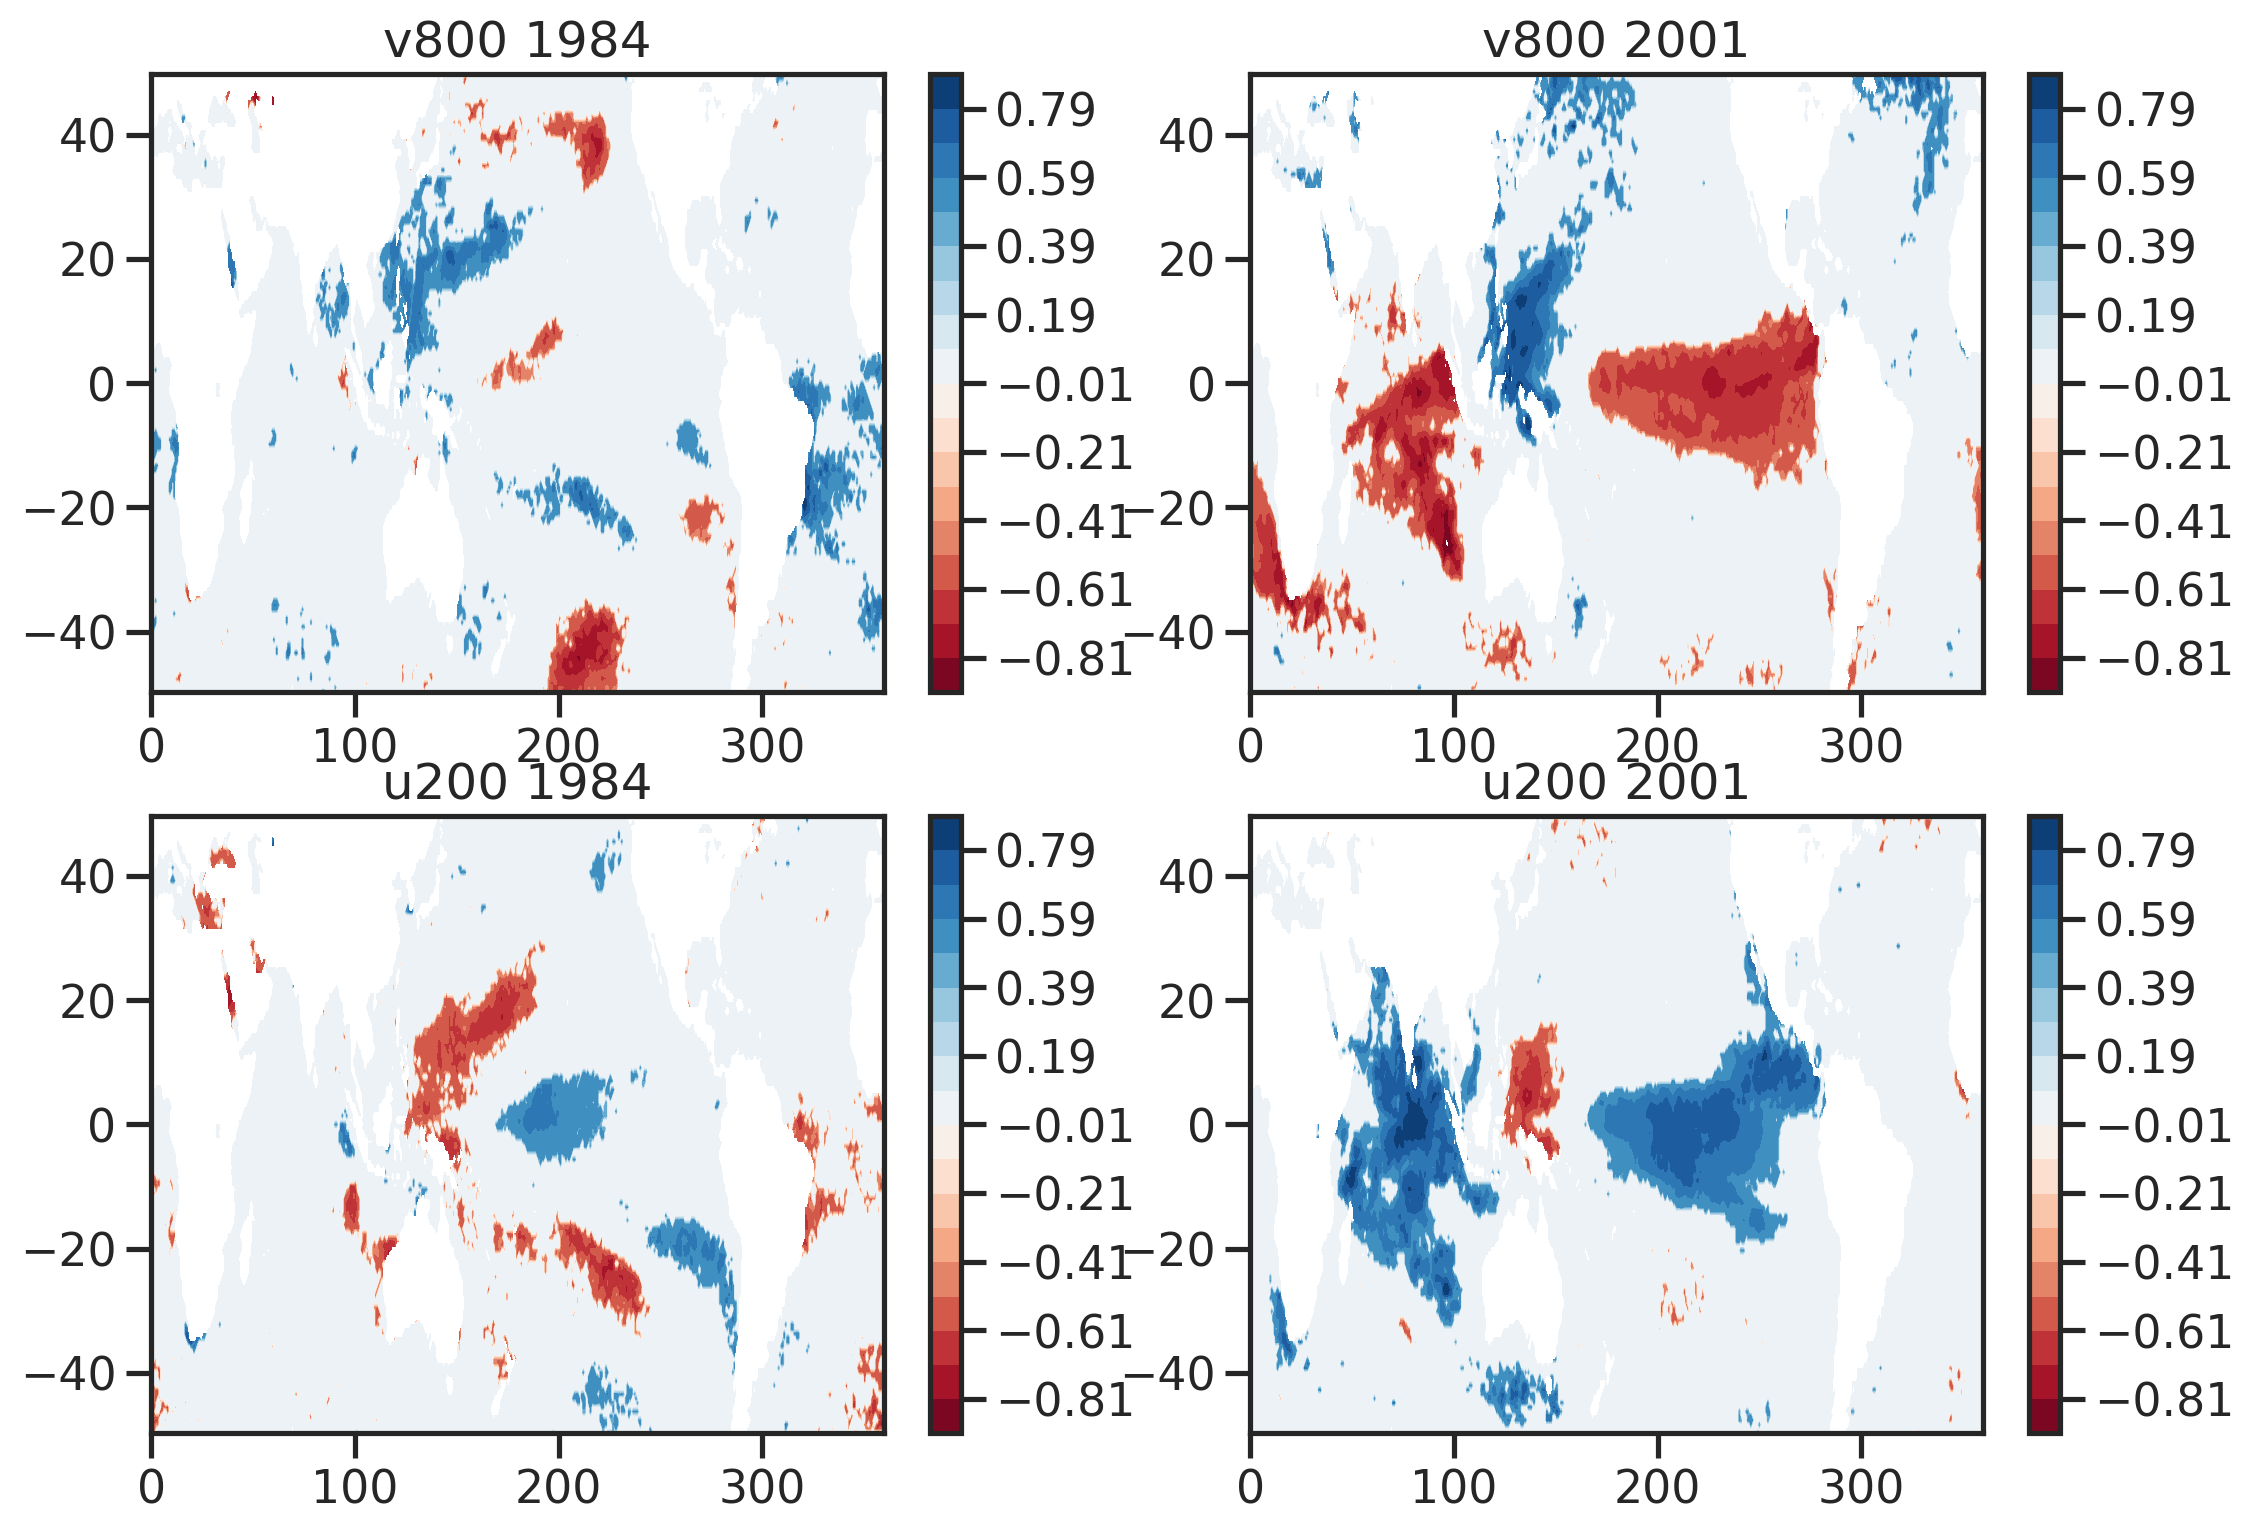

In [69]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(outloops):
    ax = f.add_subplot(2,2,ind+1)
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst_season.longitude, sst_season.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu')
    plt.colorbar()
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

In [182]:
g = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/monthly/pressure_levels/synop/ERA5_monthly_pl_*.nc')
sst = uda.flip_lat(g)

In [201]:
z = sst['q'].isel(time=sst['time.hour']==15).sel(level=600).isel(expver=0)
g_season = season_mean_sst(z) #z.sel(time=z['time.month']==2)# 
g_season = g_season.load()

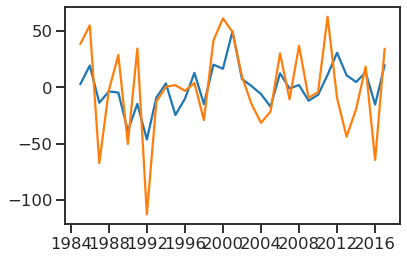

In [202]:
plt.plot(cts-np.mean(cts))
plt.plot((ets200-np.mean(ets200))*-15)

In [203]:
ploops = [(cts,1985, 1999), (cts,2000,2017), (ets200,1985,1999), (ets200,2000,2017)]
gloops = []
for pl in ploops:
    test = corr(g_season.isel(time=(g_season['time.year']>=pl[1]) & (g_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    gloops.append(test)

Did 1985
Did 2000
Did 1985
Did 2000


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


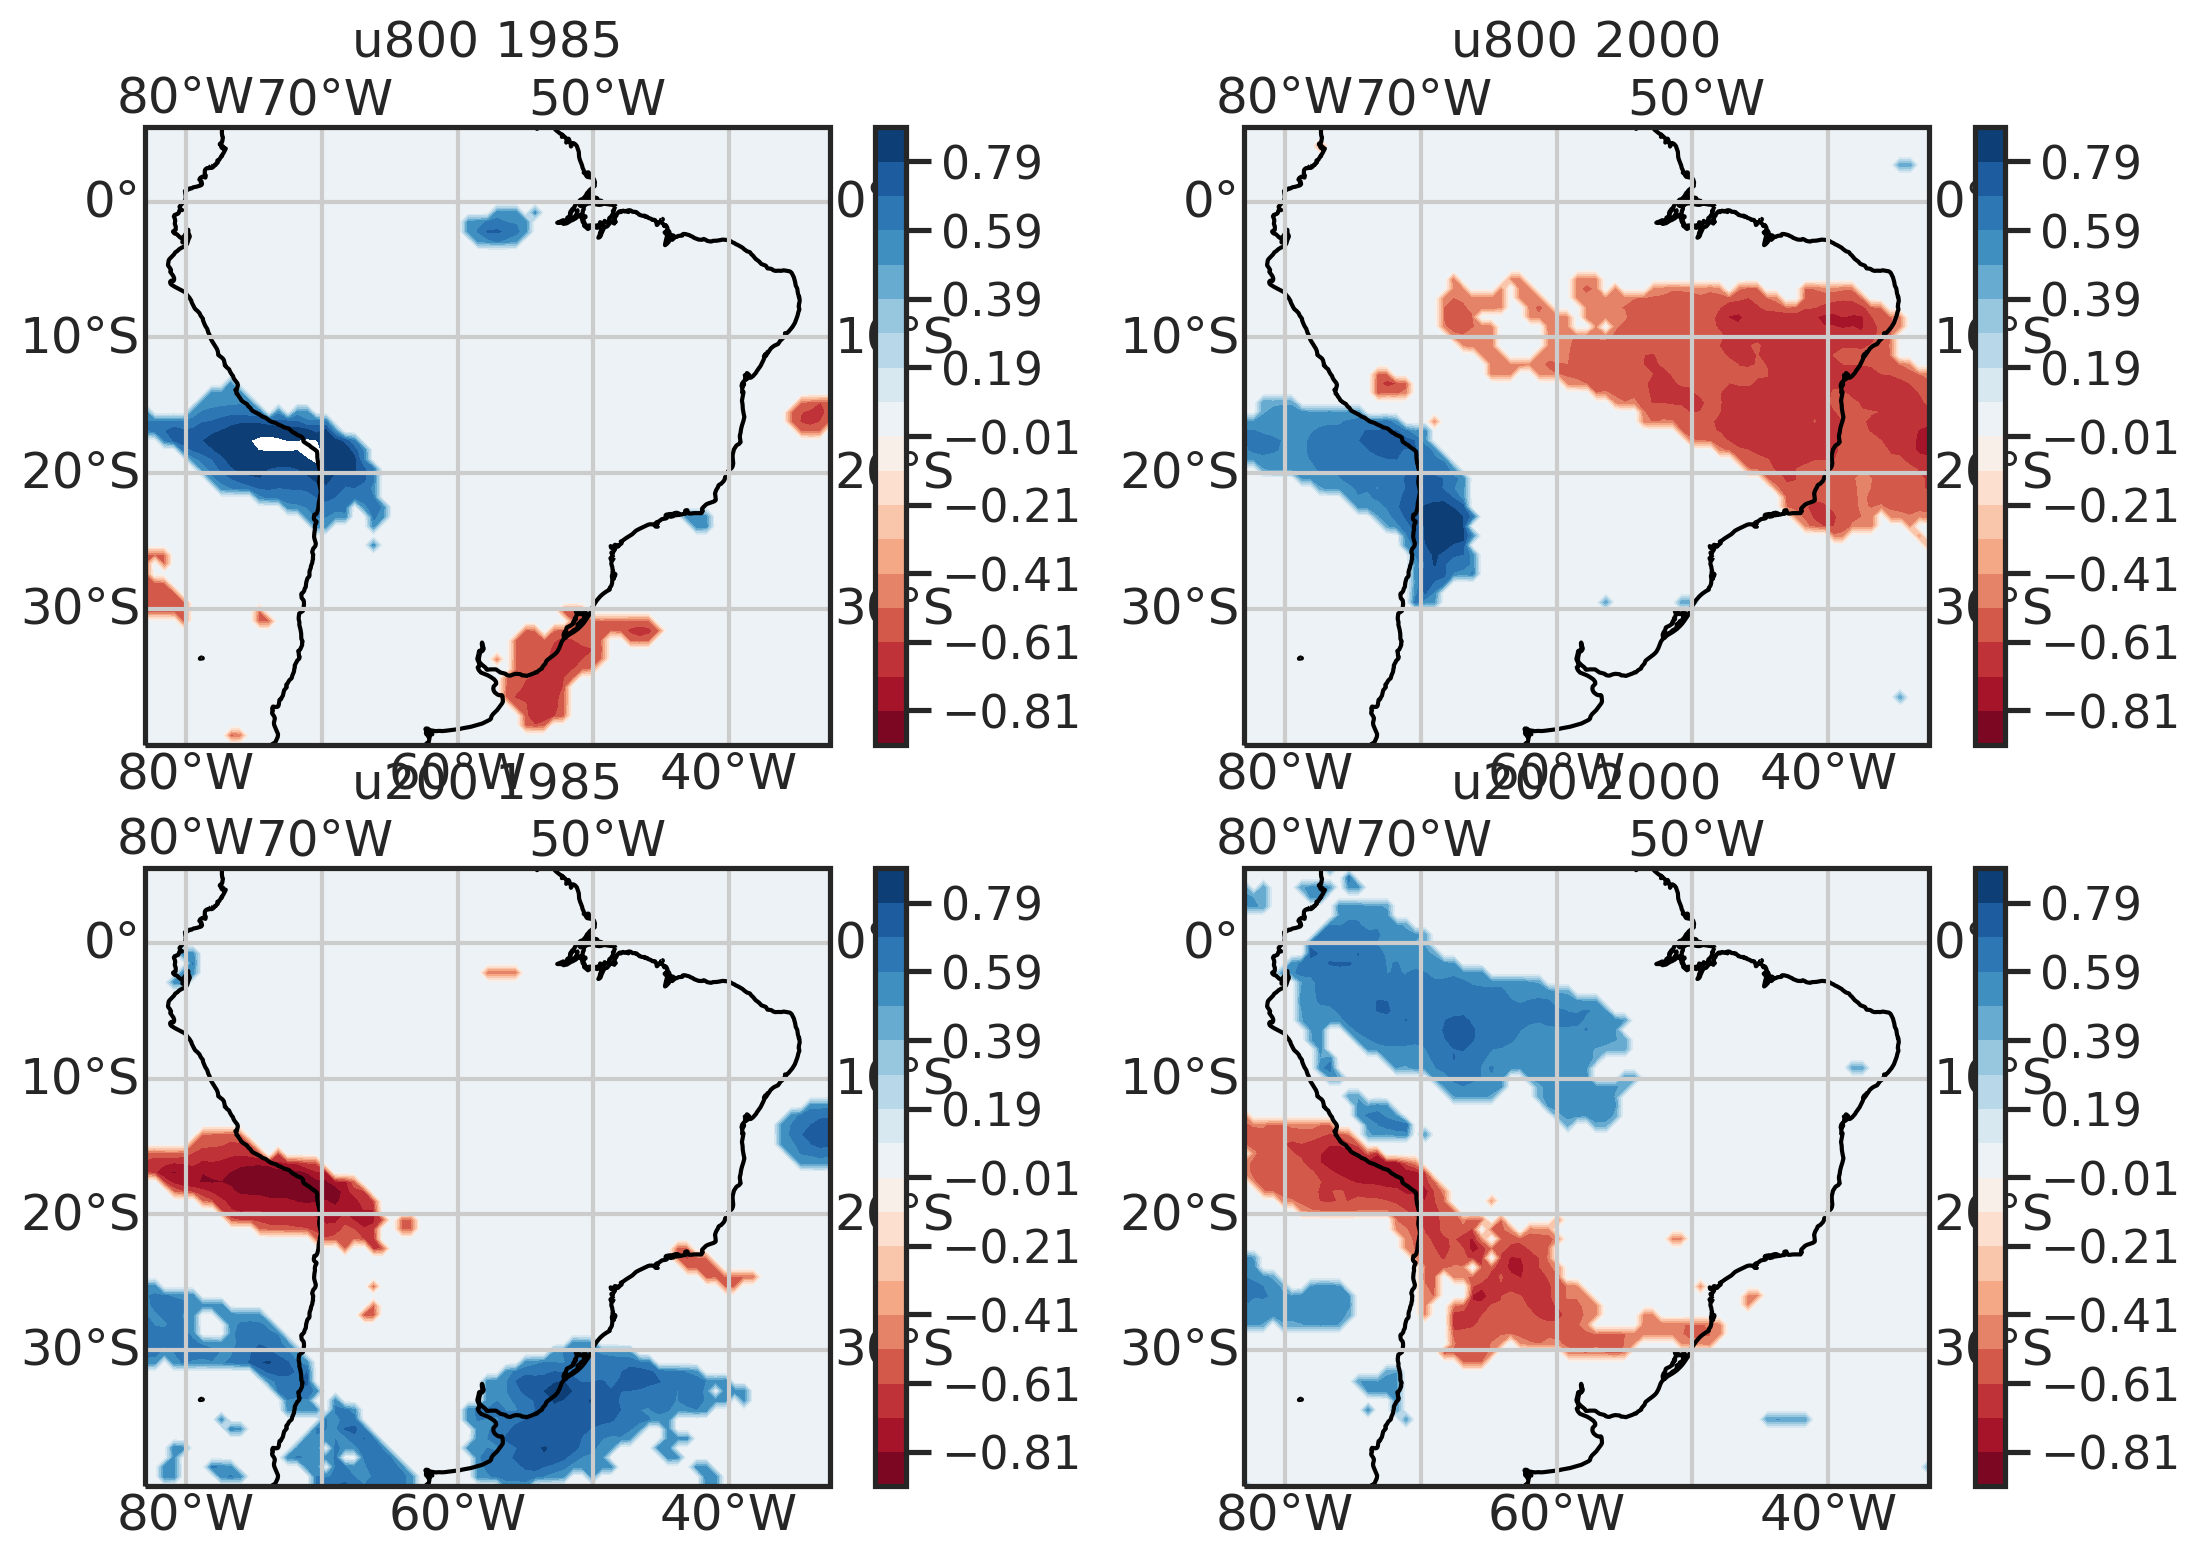

In [204]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['u800', 'u800', 'u200', 'u200']
for ind, dat in enumerate(gloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
    xl = ax.gridlines(draw_labels=True);
    #ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    
    isy = ploops[ind]
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.colorbar()
   # ipdb.set_trace()
    plt.contour(sst.longitude, sst.latitude, g_season.isel(time=((g_season['time.year']>=isy[1]) & (g_season['time.year']<=isy[2]))).mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=[-10,-5,-2,0,2,5,10])

    plt.title(pstr[ind]+' '+str(ploops[ind][1]))
#     ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
#     ax.coastlines()
#         # Gridlines
#     xl = ax.gridlines(draw_labels=True);
#     xl.xlabels_top = False
#     xl.ylabels_right = False
#     dats = dat['r'].copy(deep=True)

#     dats.values[dat['pval']>0.05] = 0
#     plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
#     plt.colorbar()
#     plt.contour(sst.longitude, sst.latitude, g_season.mean('time')/100, colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=np.arange(1190,1230,2))

#     plt.title(pstr[ind]+' '+str(ploops[ind][1]))

 

In [188]:
slices_all_b2000 = sst.where((sst['time.month']==2) & (sst['time.year']<2000)).isel(expver=1).mean('time')
slices_all_a2000 = sst.where((sst['time.month']==2) & (sst['time.year']>2000)).isel(expver=1).mean('time')

slices_all_b2000j = sst.where((sst['time.month']==1) & (sst['time.year']<2000)).isel(expver=1).mean('time')
slices_all_a2000j = sst.where((sst['time.month']==1) & (sst['time.year']>2000)).isel(expver=1).mean('time')

In [189]:
slices_all_b2000

<xarray.Dataset>
Dimensions:    (latitude: 66, level: 17, longitude: 73)
Coordinates:
    expver     int32 5
  * longitude  (longitude) float32 -83.0 -82.3 -81.6 -80.9 ... -34.0 -33.3 -32.6
  * latitude   (latitude) float32 -40.0 -39.3 -38.6 -37.9 ... 3.4 4.1 4.8 5.5
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
Data variables:
    d          (level, latitude, longitude) float32 dask.array<chunksize=(17, 66, 73), meta=np.ndarray>
    z          (level, latitude, longitude) float32 dask.array<chunksize=(17, 66, 73), meta=np.ndarray>
    r          (level, latitude, longitude) float32 dask.array<chunksize=(17, 66, 73), meta=np.ndarray>
    q          (level, latitude, longitude) float32 dask.array<chunksize=(17, 66, 73), meta=np.ndarray>
    t          (level, latitude, longitude) float32 dask.array<chunksize=(17, 66, 73), meta=np.ndarray>
    u          (level, latitude, longitude) float32 dask.array<chunksize=(17, 66, 73), meta=np.ndarray>
    v          (level, latitude, longitude) float32 dask.array<chunksize=(17, 66, 73), meta=np.ndarray>
    w          (level, latitude, longitude) float32 dask.array<chunksize=(17, 66, 73), meta=np.ndarray>

In [192]:
f = plt.figure(figsize=(17,5), dpi=100)

var = 'w'
ax = f.add_subplot(1,3,1, projection=ccrs.PlateCarree())

ll=800
llq = 600

uanodry = slices_all_b2000['u'].sel(level=ll)
vanodry = slices_all_b2000['v'].sel(level=ll) # multiplied by 10 since vertical component is very small compared to horizontal one
uanowet = slices_all_a2000['u'].sel(level=ll)
vanowet = slices_all_a2000['v'].sel(level=ll)
st=3
sarrow = 1
xquiv = slices_all_a2000.longitude[sarrow::st]
yquiv = slices_all_a2000.latitude[sarrow::st]

uud = (uanodry)[sarrow::st, sarrow::st]  
vvd = (vanodry)[sarrow::st, sarrow::st]

uuw = (uanowet)[sarrow::st, sarrow::st]  
vvw = (vanowet)[sarrow::st, sarrow::st]

ax.coastlines()
        # Gridlines
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False

#ipdb.set_trace()
    
plt.contourf(slices_all_a2000.longitude, slices_all_a2000.latitude, slices_all_b2000[var].sel(level=llq)*100, levels=np.arange(5,70,0.5), cmap='jet', transform=ccrs.PlateCarree(), extend='both')
plt.colorbar()
#plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
plt.quiver(xquiv, yquiv, uud, vvd, scale=55, width=0.002, headwidth=7)
ax.set_xlim(-81,-57)
ax.set_ylim(-25,0)
plt.title(var+' dry7')

ax = f.add_subplot(1,3,2, projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(slices_all_a2000.longitude, slices_all_a2000.latitude, slices_all_a2000[var].sel(level=llq)*100, levels=np.arange(5,70,0.5), cmap='jet', transform=ccrs.PlateCarree(), extend='both')
plt.colorbar()
#plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
plt.quiver(xquiv, yquiv, uuw, vvw, scale=55, width=0.002, headwidth=7)
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
ax.set_xlim(-81,-57)
ax.set_ylim(-25,0)
plt.title(var+' wet7')

ax = f.add_subplot(1,3,3, projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(slices_all_a2000.longitude, slices_all_a2000.latitude, (slices_all_b2000[var]-slices_all_a2000[var]).sel(level=llq)*100, levels=np.arange(-1,1.1,0.1),cmap='RdBu', transform=ccrs.PlateCarree(), extend='both')
plt.colorbar()
#plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
plt.quiver(xquiv, yquiv, (uuw-uud), (vvw-vvd), scale=55, width=0.002, headwidth=7)
xl = ax.gridlines(draw_labels=True);
xl.xlabels_top = False
xl.ylabels_right = False
ax.set_xlim(-81,-57)
ax.set_ylim(-25,0)
plt.title(var+'200 wet7-dry7')

plt.tight_layout()

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attrib

In [266]:
from utils import constants as cnst, u_met
u = sst['u'].isel(time=sst['time.hour']==15).sel(level=850).isel(expver=0)
v = sst['v'].isel(time=sst['time.hour']==15).sel(level=850).isel(expver=0)

ws= u_met.u_v_to_ws_wd(u.values, v.values)
z = u.copy(deep=True)
z.name = 'ws'

z.values = ws[0]
g_season = season_mean_sst(z)
g_season = g_season.load()

In [274]:
ploops = [(ett850,1984, 2000), (ett850,2001,2017), (ets200,1984,2000), (ets200,2001,2017)]
gloops = []
for pl in ploops:
    test = corr(g_season.isel(time=(g_season['time.year']>=pl[1]) & (g_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    gloops.append(test)

Did 1984
Did 2001
Did 1984
Did 2001


In [277]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 'u200', 'u200']

for ind, dat in enumerate(gloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
    xl = ax.gridlines(draw_labels=True);
    #ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    
    isy = ploops[ind]
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.colorbar()
   # ipdb.set_trace()
    plt.contour(sst.longitude, sst.latitude, g_season.isel(time=((g_season['time.year']>=isy[1]) & (g_season['time.year']<=isy[2]))).mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=[-10,-5,-2,0,2,5,10])

    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

In [44]:
z = sst['t'].isel(time=sst['time.hour']==15).sel(level=925).isel(expver=0)
g_season = season_mean_sst(z)
g_season = g_season.load()

In [47]:
ploops = [(etq850,1984, 2000), (etq850,2001,2017), (ets200,1984,2000), (ets200,2001,2017)]
gloops = []
for pl in ploops:
    test = corr(g_season.isel(time=(g_season['time.year']>=pl[1]) & (g_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    gloops.append(test)

Did 1984
Did 2001
Did 1984
Did 2001


In [48]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(gloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
        # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    dats = dat['r'].copy(deep=True)
    
    ax.add_patch(mpatches.Rectangle(xy=[peru[0], peru[2]], width=peru[1]-peru[0], height=peru[3]-peru[2],
                                    facecolor='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree())
                 )
    
    dats.values[dat['pval']>0.1] = 0
    plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.colorbar()
    plt.contour(sst.longitude, sst.latitude, g_season.mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree()) #, levels=np.arange(-10,11,1)
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attrib

T / q: positive correlated, constant since 1984
T / u200: positive correlated, stronger / only visible since 2001 >> 
T / v850: positive correlated along southern peruvian and Amazon belt, stable since 1984, slightly weaker / more spread out since 2001
v850 / u200: positive correlated, only strongly visible since 2001
gts in peru / sst: negatively correlated, warmer SST means less convection in peru, shows much stronger since 2001, almost non-existent pre-2001


In [90]:
z = sst['t'].isel(time=sst['time.hour']==15).sel(level=925).isel(expver=0)
g_season = season_mean_sst(z)
g_season = g_season.load()

In [91]:
ploops = [(ets,1984, 2000), (ets,2001,2017), (ets200,1984,2000), (ets200,2001,2017)]
gloops = []
for pl in ploops:
    test = corr(g_season.isel(time=(g_season['time.year']>=pl[1]) & (g_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    gloops.append(test)

Did 1984
Did 2001
Did 1984
Did 2001


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attrib

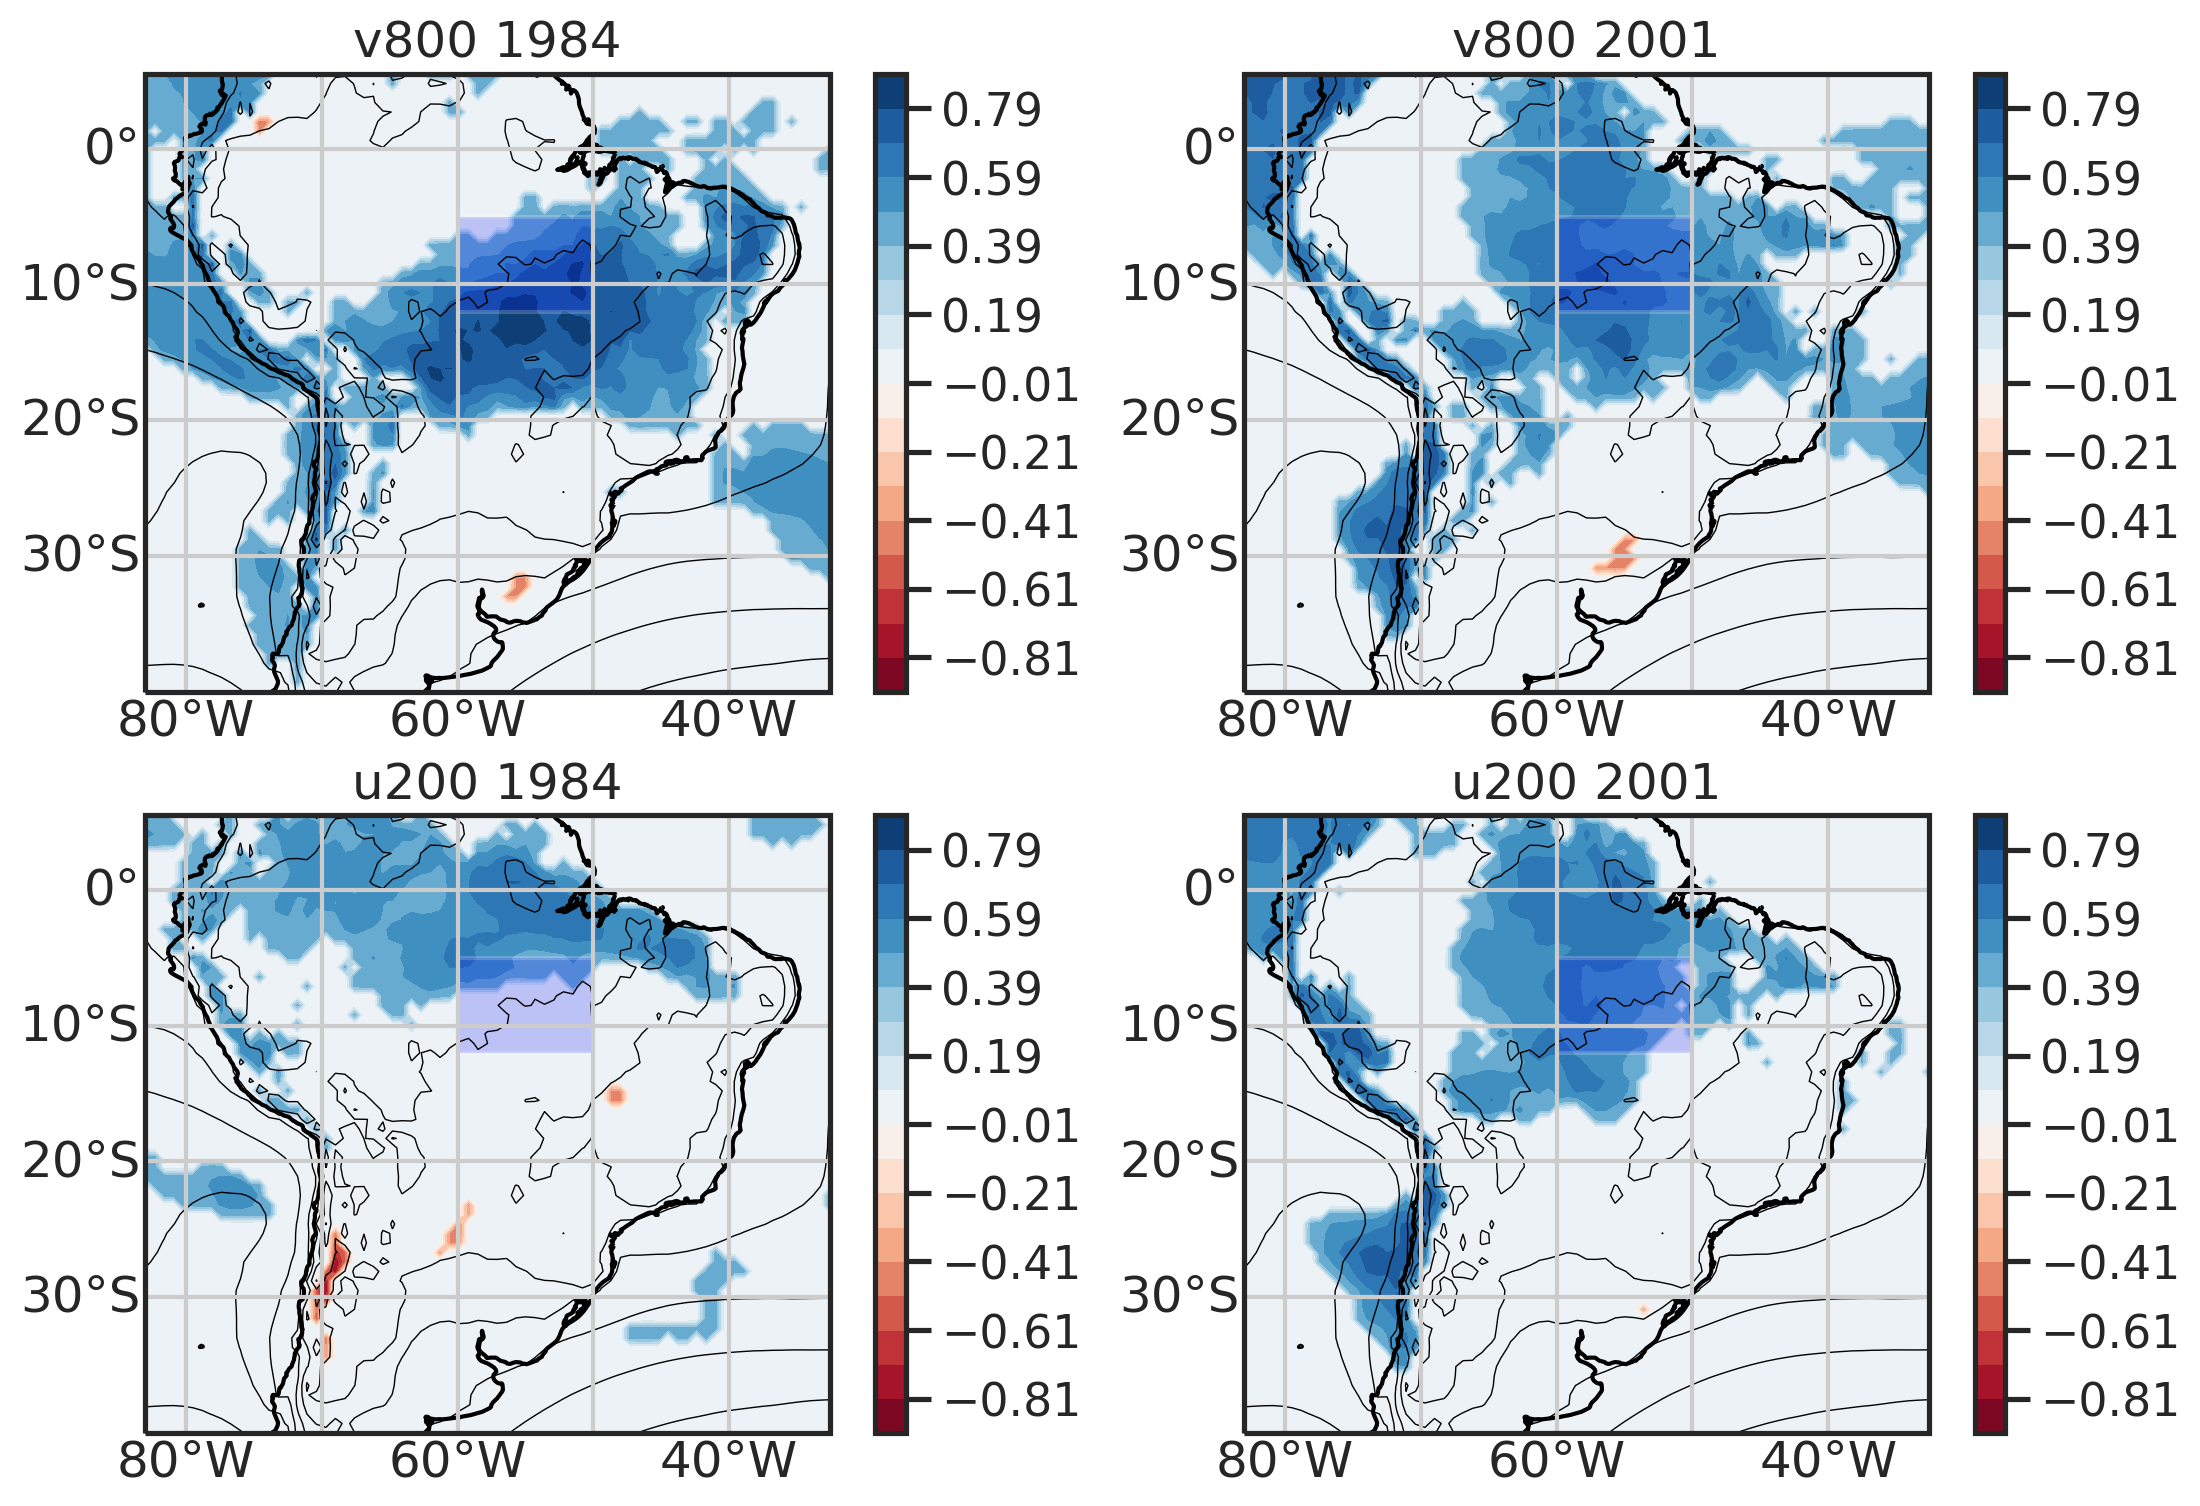

In [92]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 'u200', 'u200']
for ind, dat in enumerate(gloops):
    ax = f.add_subplot(2,2,ind+1, projection=ccrs.PlateCarree())
    ax.coastlines()
        # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    dats = dat['r'].copy(deep=True)
    
    ax.add_patch(mpatches.Rectangle(xy=[tbox[0], tbox[2]], width=tbox[1]-tbox[0], height=tbox[3]-tbox[2],
                                    facecolor='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree())
                 )
    
    dats.values[dat['pval']>0.1] = 0
    plt.contourf(sst.longitude, sst.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.colorbar()
    plt.contour(sst.longitude, sst.latitude, g_season.mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree()) #, levels=np.arange(-10,11,1)
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))

In [137]:
ploops = [(gts,1984, 2000), (gts,2001,2017), (ett850,1984,2000), (ett850,2001,2017)]
outloops = []
for pl in ploops:
    test = corr(sst_season.isel(time=(sst_season['time.year']>=pl[1]) & (sst_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    outloops.append(test)

/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Did 1984


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Did 2001


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Did 1984


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Did 2001


In [139]:
f = plt.figure(figsize=(13,9), dpi=200)
pstr = ['v800', 'v800', 't850', 't850']
for ind, dat in enumerate(outloops):
    ax = f.add_subplot(2,2,ind+1)
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0
    plt.contourf(sst_season.longitude, sst_season.latitude, dats, levels=np.arange(-0.91,0.91,0.1), cmap='RdBu')
    plt.colorbar()
    plt.title(pstr[ind]+' '+str(ploops[ind][1]))